(Reliability Statistics and Predictive Calibration)=
# Reliability Statistics and Predictive Calibration

:::{post} January, 2023
:tags: time-to-failure, prediction, calibration
:category: intermediate
:author: Nathaniel Forde
:::

In [178]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import lognorm, norm
from io import StringIO

from pymc.sampling_jax import sample_blackjax_nuts

In [ ]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Reliability Statistics 

When we want to make inferences about likely failures on a production line we may have large or small sample data set depending on the industry, nature of the goods or specificifty of the question we're seeking to answer. But in all cases there is a question of cost and a quantity of tolerable failures. In an industry where the line-item cost-profit ratio is clear, the estimation of failure rates is valuable. In an industry where failures are only tangentially related to a bottom line it is arguably even more crucial to correctly predict likely failures, otherwise the uncertainty propagates forward to make the revenue calculations next to impossible. 

A reliability study therefore has to account for the period in which a failure is important to observe, the cost of the failure and cost of running a mis-specified study. The requirements for precision in the definition of the question and the nature of the modelling exercise are paramount. 

There are more subtleties about reliability and failure time data such as censoring, accelerated life test data and degradation testing that are too complex to go into here. We're going to focus on the prediction of failure times and compare the Bayesian notion of a calibrated prediction interval to some frequentist alternatives. 

### Types of Prediction

We might want to know:

- Time to failure of a new item
- Time until k failures in a future sample of m units
- Number of failures by time t in future sample of m units.

While there are non-parametric and descriptive methods that can be used to assess these kinds of question we're going to focus on the case where we have a probability model i.e. a lognormal distribution of failure times $F(t: \mathbf{\theta})$ parameterised by an unknown $\mathbf{\theta}$. 

### Example Failure Distribution

In the study of reliability statistics there is a focus on location-scale based distributions with long tails. 

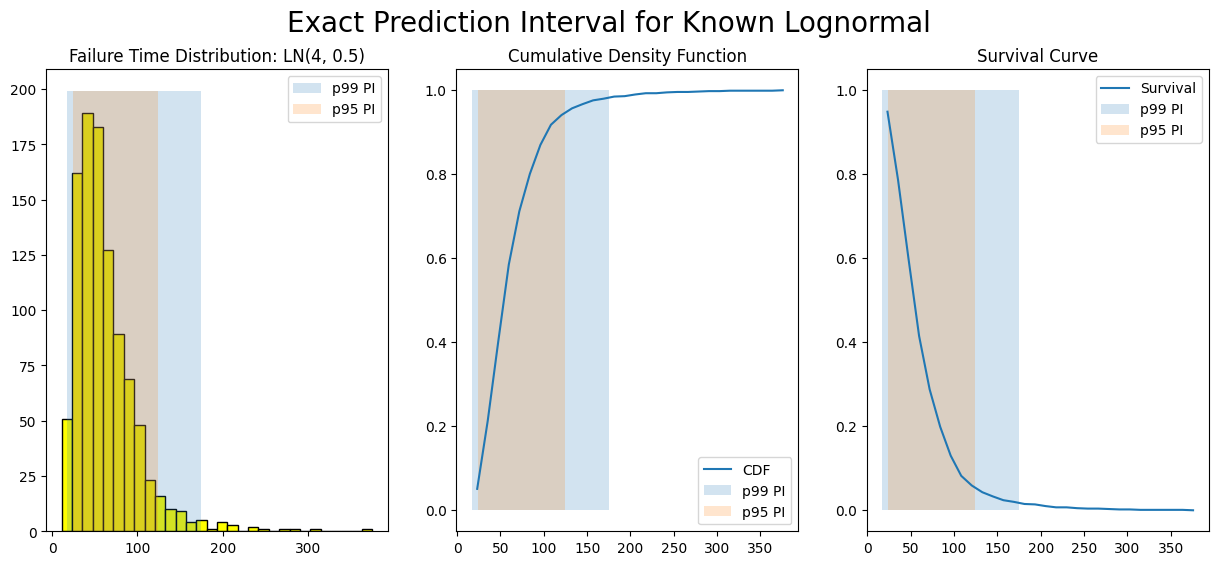

In [167]:
from scipy.stats import lognorm
mu, sigma = 4,  0.5
failure_dist = lognorm(s=sigma, scale=np.exp(mu))
samples = failure_dist.rvs(size=1000, random_state=100)
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()
axs[0].hist(samples, ec='black', color='yellow', bins=30)
axs[0].set_title("Failure Time Distribution: LN(4, 0.5)")
count, bins_count = np.histogram(samples, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
axs[1].plot(bins_count[1:], cdf, label="CDF")
axs[2].plot(bins_count[1:], 1-cdf, label="Survival")
axs[2].legend()
axs[1].legend()
axs[1].set_title("Cumulative Density Function")
axs[2].set_title("Survival Curve");

lb = failure_dist.ppf(0.01)
ub = failure_dist.ppf(0.99)
axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label='p99 PI')
axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p99 PI')
axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p99 PI')
lb = failure_dist.ppf(0.05)
ub = failure_dist.ppf(0.95)
axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label='p95 PI')
axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p95 PI')
axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p95 PI')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle("Exact Prediction Interval for Known Lognormal", fontsize=20);

## Estimation of the Failure Distribution from Data

We will examine failure data about heat exchanges across three plants

In [248]:
heat_exchange_df = pd.read_csv(StringIO("""Years Lower,Years Upper,Censoring Indicator,Count,Plant
0,1,Left,1,1
1,2,Interval,2,1
2,3,Interval,2,1
3, ,Right,95,1
0,1,Left,2,2
1,2,Interval,3,2
2, ,Right,95,2
0,1,Left,1,3
1, ,Right,99,3

"""))

heat_exchange_df['year_interval'] =  heat_exchange_df['Years Lower'].astype(str) + ',' +   heat_exchange_df['Years Upper'].astype(str)
heat_exchange_df['failed'] = np.where(heat_exchange_df['Censoring Indicator'] != 'Right', heat_exchange_df['Count'], 0)
heat_exchange_df['censored'] = np.where(heat_exchange_df['Censoring Indicator'] == 'Right', heat_exchange_df['Count'], 0)
heat_exchange_df['risk_set'] = [100, 99, 97, 0, 100, 98, 0, 100, 0]
heat_exchange_df

,Years Lower,Years Upper,Censoring Indicator,Count,Plant,year_interval,failed,censored,risk_set
0,0,1,Left,1,1,"0,1",1,0,100
1,1,2,Interval,2,1,"1,2",2,0,99
2,2,3,Interval,2,1,"2,3",2,0,97
3,3,,Right,95,1,"3,",0,95,0
4,0,1,Left,2,2,"0,1",2,0,100
5,1,2,Interval,3,2,"1,2",3,0,98
6,2,,Right,95,2,"2,",0,95,0
7,0,1,Left,1,3,"0,1",1,0,100
8,1,,Right,99,3,"1,",0,99,0


In [319]:
actuarial_table = heat_exchange_df.groupby(['Years Upper'])[['failed', 'risk_set']].sum()
actuarial_table['p_hat'] = actuarial_table['failed'] / actuarial_table['risk_set'] 
actuarial_table['1-p_hat'] = 1 - actuarial_table['p_hat']
actuarial_table['S_hat'] = actuarial_table['1-p_hat'].cumprod()
actuarial_table['F_hat'] = 1 - actuarial_table['S_hat']
actuarial_table = actuarial_table.dropna()
actuarial_table

,failed,risk_set,p_hat,1-p_hat,S_hat,F_hat
Years Upper,,,,,,
1,4,300,0.013333,0.986667,0.986667,0.013333
2,5,197,0.025381,0.974619,0.961624,0.038376
3,2,97,0.020619,0.979381,0.941797,0.058203


In [332]:
def greenwood_variance(df):
    n = len(df) 
    ps = [df.iloc[i]['p_hat'] / (df.iloc[i]['risk_set']*df.iloc[i]['1-p_hat']) for i in range(n)]
    s = [(df.iloc[i]['S_hat']**2)*np.sum(ps[0:i+1]) for i in range(n)]
    return s

def logit_transform_interval(df):
    df['logit_CI_95_lb'] = df['F_hat'] / (df['F_hat'] + df['S_hat']*np.exp((1.960*df['Standard_Error'])/(df['F_hat']*df['S_hat'])))
    df['logit_CI_95_ub'] = df['F_hat'] / (df['F_hat'] + df['S_hat']/np.exp((1.960*df['Standard_Error'])/(df['F_hat']*df['S_hat'])))
    return df

actuarial_table['V_hat'] = greenwood_variance(actuarial_table)
actuarial_table['Standard_Error'] = np.sqrt(actuarial_table['V_hat'])
actuarial_table['CI_95_lb'] = actuarial_table['F_hat'] - actuarial_table['Standard_Error']*1.960
actuarial_table['CI_95_ub'] = actuarial_table['F_hat'] + actuarial_table['Standard_Error']*1.960
actuarial_table  = logit_transform_interval(actuarial_table)
actuarial_table


,failed,risk_set,p_hat,1-p_hat,S_hat,F_hat,V_hat,Standard_Error,CI_95_lb,CI_95_ub,logit_CI_95_lb,logit_CI_95_ub
Years Upper,,,,,,,,,,,,
1,4,300,0.013333,0.986667,0.986667,0.013333,0.000044,0.006622,0.000354,0.026313,0.005013,0.034977
2,5,197,0.025381,0.974619,0.961624,0.038376,0.000164,0.012802,0.013283,0.063468,0.019818,0.073016
3,2,97,0.020619,0.979381,0.941797,0.058203,0.000350,0.018701,0.021550,0.094856,0.030694,0.107629


<AxesSubplot: xlabel='Years Upper'>

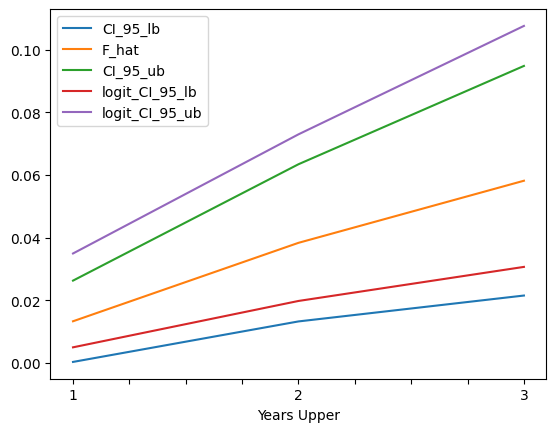

In [333]:
actuarial_table[['CI_95_lb','F_hat', 'CI_95_ub', 'logit_CI_95_lb', 'logit_CI_95_ub']].plot()

### Probability Plots as Goodness of Fit Checks



/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/3313517724.py:12: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(lognorm.ppf(qs, s=0.5, scale=np.exp(4))), norm.ppf(qs), label="LN(4, 0.5)");
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/3313517724.py:13: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(lognorm.ppf(qs, s=0.5, scale=np.exp(5))), norm.ppf(qs), label="LN(5, 0.5)");
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/3313517724.py:14: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(lognorm.ppf(qs, s=0.3, scale=np.exp(5))), norm.ppf(qs), label="LN(5, 0.3)");
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/3313517724.py:15: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(lognorm.ppf(qs, s=0.7, scale=np.exp(3))), norm.ppf(qs), label="LN(3, 0.7)");


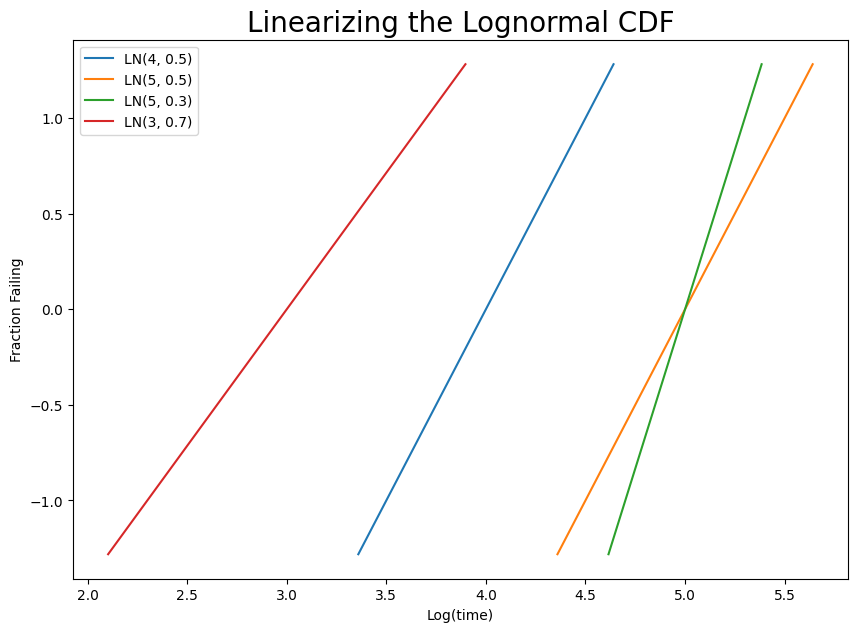

In [176]:
def lognorm_cdf(mu, sigma, t):
    p = (np.log(t) - mu) / sigma
    return norm.cdf(p, 0, 1)

def lognorm_quantile(mu, sigma, q):
    q = mu + norm.ppf(q, 0, 1)*sigma
    return np.exp(q)

ts = [0, 1, 3, 4, 5, 50, 100, 200]
qs = [0, .1, .2, .3, .4, .5, .7, .9, 1]
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log(lognorm.ppf(qs, s=0.5, scale=np.exp(4))), norm.ppf(qs), label="LN(4, 0.5)");
ax.plot(np.log(lognorm.ppf(qs, s=0.5, scale=np.exp(5))), norm.ppf(qs), label="LN(5, 0.5)");
ax.plot(np.log(lognorm.ppf(qs, s=0.3, scale=np.exp(5))), norm.ppf(qs), label="LN(5, 0.3)");
ax.plot(np.log(lognorm.ppf(qs, s=0.7, scale=np.exp(3))), norm.ppf(qs), label="LN(3, 0.7)");
ax.set_title("Linearizing the Lognormal CDF", fontsize=20)
ax.legend()
ax.set_xlabel("Log(time)")
ax.set_ylabel("Fraction Failing");


In [89]:
bearings = pd.DataFrame(
    {'millions_of_cycles':[17.88, 28.92, 33, 41.52, 42.12, 45.6, 48.4, 51.84,
                           51.96, 54.12, 55.56,67.8, 68.64, 68.64, 68.88, 84.12,
                           93.12, 98.64, 105.12, 105.84, 127.92, 128.04, 173.4]})
bearings['censored'] = np.where(bearings.index < 15, 0, 1)
bearings.T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
millions_of_cycles,17.88,28.92,33.0,41.52,42.12,45.6,48.4,51.84,51.96,54.12,...,68.64,68.88,84.12,93.12,98.64,105.12,105.84,127.92,128.04,173.4
censored,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [150]:
fit_params = lognorm.fit(bearings[bearings['censored']==0]['millions_of_cycles'])
fit_params


(9.166498050871674, 17.879999999999995, 2.272875577268884)

In [152]:
np.log(2.2)

0.7884573603642703

## Authors

Nathaniel Forde

## Watermark

In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Wed Dec 14 2022

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

aesara: 2.8.7
aeppl : 0.0.38
xarray: 2022.10.0

sys: 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]

Watermark: 2.3.1



:::{include} ../page_footer.md
:::